In [152]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras_tuner import HyperModel, RandomSearch
from sklearn.preprocessing import RobustScaler, QuantileTransformer, PowerTransformer, StandardScaler, MinMaxScaler
import joblib

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [153]:
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPUs Available:  0


In [154]:
# Load the data
csv_file2 = '/Users/ratchanonkhongsawi/Desktop/CMKL/2nd/RND2/1_break_1/Data/cleaned_ladpo_v2.csv'
df2 = pd.read_csv(csv_file2)
df2

,date_time,Temperature,Conductivity,TDS,Salinity,DO,Sensor_Depth,pH,Chlorophyll,Turbid
0,2014-05-07 14:00:00,31.818333,4.666667,3001.666667,2.436667,0.0,11.271667,-1.055000,0.0,0.0
1,2014-05-07 15:00:00,31.763333,4.000000,2843.333333,2.296667,0.0,11.120000,-1.063333,0.0,0.0
2,2014-05-07 16:00:00,31.610000,3.000000,2126.666667,1.693333,0.0,10.950000,-1.096667,0.0,0.0
3,2014-05-07 17:00:00,31.533333,3.000000,1803.333333,1.420000,0.0,10.963333,-1.090000,0.0,0.0
4,2014-05-07 19:00:00,31.346667,2.000000,1121.666667,0.863333,0.0,11.531667,-1.056667,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
66542,2024-07-25 18:00:00,30.521667,379.666667,246.666667,0.180000,0.0,1.201667,0.000000,0.0,0.0
66543,2024-07-25 19:00:00,30.530000,371.000000,240.000000,0.178333,0.0,1.951667,0.000000,0.0,0.0
66544,2024-07-25 20:00:00,30.516667,375.500000,245.000000,0.180000,0.0,2.421667,0.000000,0.0,0.0
66545,2024-07-25 21:00:00,30.501667,380.833333,250.000000,0.180000,0.0,2.628333,0.000000,0.0,0.0


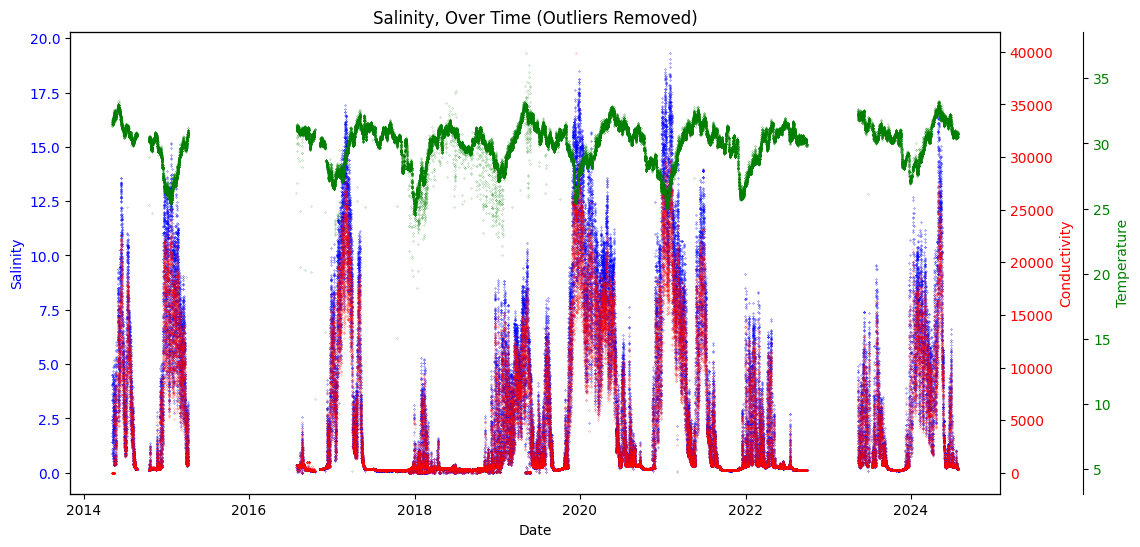

In [155]:

# Convert date_time to datetime format and set as the index
df2['date_time'] = pd.to_datetime(df2['date_time'], format='%Y-%m-%d %H:%M:%S')
df2['date_time_copy'] = df2['date_time']
df2.set_index('date_time', inplace=True)

# Filter for columns 'Salinity' and 'Sensor_Depth' and remove rows with NaN values
# df2 = df2.loc[: , ['Salinity']]

# Plot both columns
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Salinity data
ax1.plot(df2.index, df2['Salinity'], '.', markersize=0.5, label='Salinity', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Salinity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the scaled Sensor_Depth
ax2 = ax1.twinx()
ax2.plot(df2.index, df2['Conductivity'], '.', markersize=0.3, label='Conductivity', color='r')
ax2.set_ylabel('Conductivity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset for the third axis
ax3.plot(df2.index, df2['Temperature'], '.', markersize=0.3, label='Temperature', color='g')
ax3.set_ylabel('Temperature', color='g')
ax3.tick_params(axis='y', labelcolor='g')

# Title and show plot
plt.title('Salinity, Over Time (Outliers Removed)')
plt.show()

In [156]:
df = df2.loc['2019-01-01':,['Salinity','date_time_copy']].interpolate()
df = df[(df['Salinity'] > 0) & (df['Salinity'] <= 33)]

In [157]:
date_time_copy = df.pop('date_time_copy')
timestamp_s = date_time_copy.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [158]:
df[['Salinity']] = df[['Salinity']].interpolate()

In [159]:
# Define column indices dictionary for df
column_indices = {name: i for i, name in enumerate(df.columns)}

# Split data into training, validation, and test sets
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Define number of features based on df1's columns
num_features = df.shape[1]

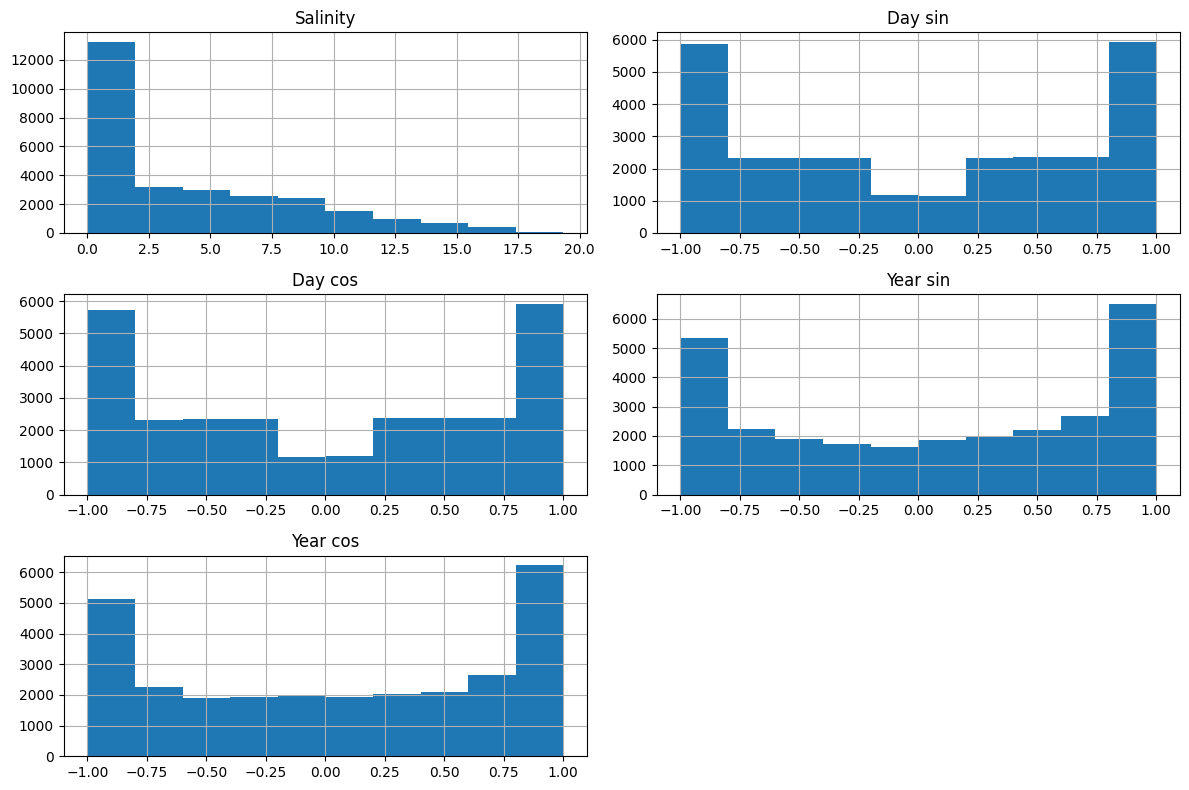

In [160]:
train_df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [161]:
# Step 1: Log Transformation
train_df.loc[:, 'Salinity'] = np.log1p(train_df['Salinity'])
val_df.loc[:, 'Salinity'] = np.log1p(val_df['Salinity'])
test_df.loc[:, 'Salinity'] = np.log1p(test_df['Salinity'])

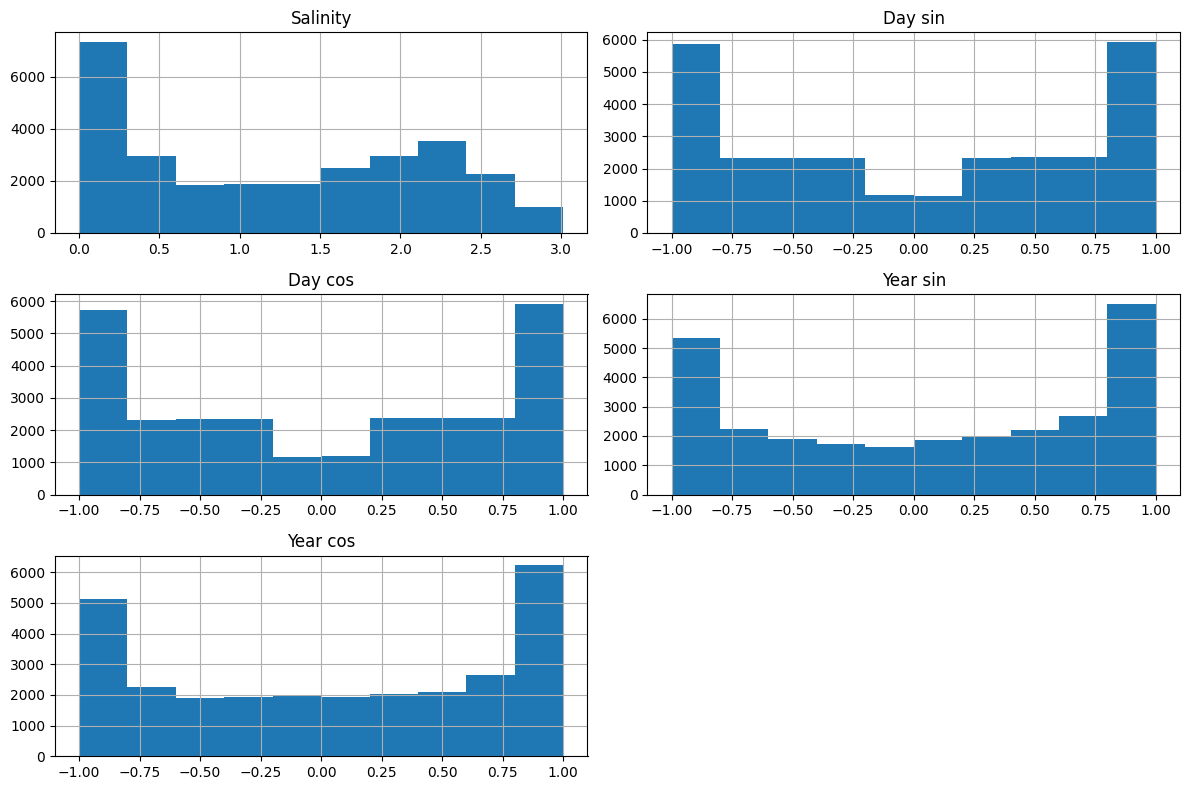

In [162]:
train_df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [163]:
# Step 2: Robust Scaling
scaler1 = RobustScaler()
scaler2 = QuantileTransformer()

# Apply RobustScaler using .loc to avoid warnings
train_df.loc[:, 'Salinity'] = scaler1.fit_transform(train_df[['Salinity']])
val_df.loc[:, 'Salinity'] = scaler1.transform(val_df[['Salinity']])
test_df.loc[:, 'Salinity'] = scaler1.transform(test_df[['Salinity']])

train_df.loc[:, 'Salinity'] = scaler2.fit_transform(train_df[['Salinity']])
val_df.loc[:, 'Salinity'] = scaler2.transform(val_df[['Salinity']])
test_df.loc[:, 'Salinity'] = scaler2.transform(test_df[['Salinity']])

In [164]:
# Save the scaler and preprocessing parameters
preprocessing_params = {
    'RobustScaler': scaler1,
    'QuantileTransformer': scaler2,
}

# Save the dictionary
joblib.dump(preprocessing_params, '/Users/ratchanonkhongsawi/Desktop/CMKL/2nd/RND2/1_break_1/Models/lstm64_preprocessing_params.pkl')

['/Users/ratchanonkhongsawi/Desktop/CMKL/2nd/RND2/1_break_1/Models/lstm64_preprocessing_params.pkl']

/var/folders/g5/m8q22yr95qb29lq55z_6_d7r0000gn/T/ipykernel_65482/2955195469.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


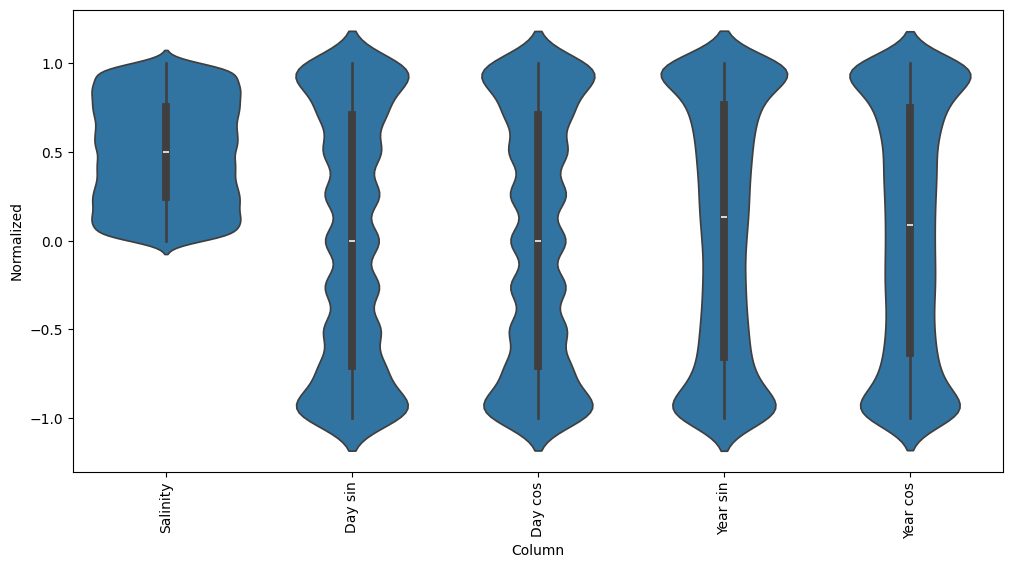

In [165]:
df_melt = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_melt)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [166]:
import numpy as np
import tensorflow as tf

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=None, val_df=None, test_df=None,
               label_columns=None):
    if train_df is None or val_df is None or test_df is None:
        raise ValueError("train_df, val_df, and test_df must be provided.")

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  @property 
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df, shuffle=False)

  @property
  def test(self):
    return self.make_dataset(self.test_df, shuffle=False)
  
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      result = next(iter(self.train))
      self._example = result
    return result
  
  def make_dataset(self, data, shuffle=True):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=32,)

    ds = ds.map(self.split_window)
    return ds

  def split_window(self, window):
      inputs = window[:, self.input_slice, :]
      labels = window[:, self.labels_slice, :]
      if self.label_columns is not None:
          labels = tf.stack(
              [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
      return inputs, labels

In [167]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Salinity'])
w1

ValueError: train_df, val_df, and test_df must be provided.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 5)
Inputs shape: (3, 24, 5)
Labels shape: (3, 1, 1)


In [ ]:
def plot(self, model=None, plot_col='Salinity', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Date')

WindowGenerator.plot = plot

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df,  # Provide actual DataFrame
    val_df=val_df,      # Provide actual DataFrame
    test_df=test_df,    # Provide actual DataFrame
    label_columns=['Salinity']
)

ValueError: train_df, val_df, and test_df must be provided.

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['Salinity'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

TypeError: WindowGenerator.make_dataset() got an unexpected keyword argument 'shuffle'

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Salinity'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Salinity']

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 5)
Output shape: (32, 24, 1)


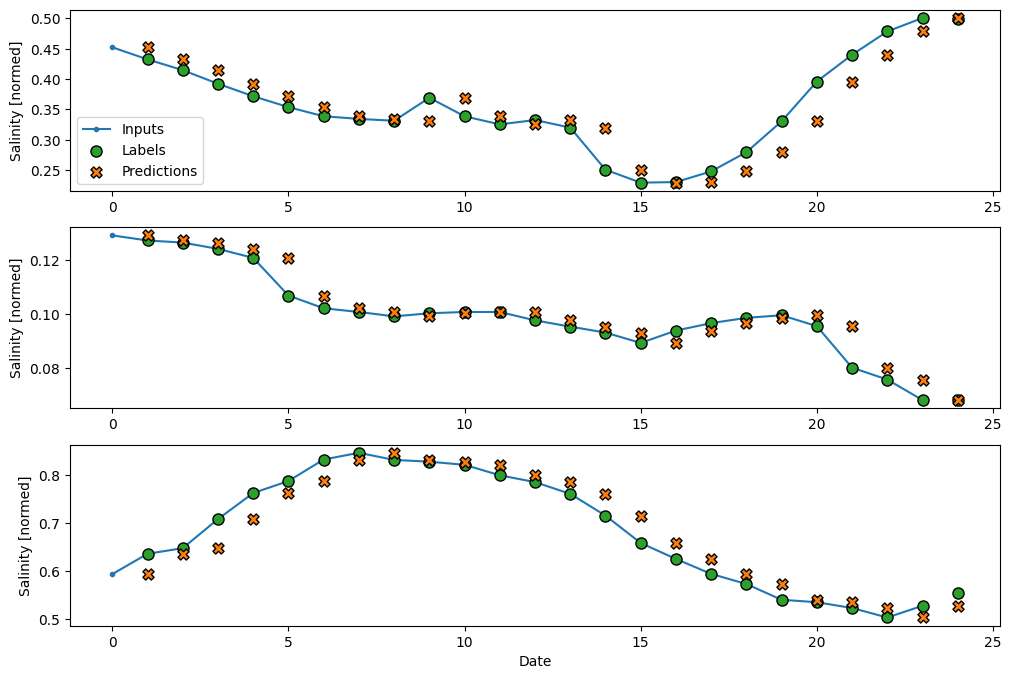

In [ ]:
wide_window.plot(baseline)

In [ ]:
MAX_EPOCHS = 30

# Define exponential decay schedule
initial_lr = 0.001  # Starting learning rate
decay_steps = 1000  # Number of steps before applying decay
decay_rate = 0.96  # Decay rate

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False  # Smooth exponential decay; use True for discrete steps
)

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
LSTM_Model = tf.keras.models.Sequential(
    [
    # LSTM layers
    tf.keras.layers.LSTM(128, return_sequences=True),
    # TimeDistributed Dense for output
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
    ],
    name='LSTM_Model')

/Users/ratchanonkhongsawi/anaconda3/envs/watergate/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
list_of_models = [LSTM_Conv1D_Model, LSTM_Model]

In [ ]:
for model in list_of_models:
    print(f'Model: {model.name}')
    val_performance[f'{model.name}'] = []
    performance[f'{model.name}'] = []
    num_range = 1
    for i in range(num_range):
        print(f'Model: {model.name} Iteration {i+1}')
        history = compile_and_fit(model, wide_window)
        IPython.display.clear_output()
        val_performance[f'{model.name}'].append(model.evaluate(wide_window.val, return_dict=True))
        performance[f'{model.name}'].append(model.evaluate(wide_window.test, return_dict=True))
    if num_range == 1:
        model.save(f'/Users/ratchanonkhongsawi/Desktop/CMKL/2nd/FALL/RND2/1_break_1/Models/{model.name}.keras')
        print(f'{model.name} saved')

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.7720e-05 - mean_absolute_error: 0.0038
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.7407e-05 - mean_absolute_error: 0.0028
LSTM_Model_64_2 saved


In [ ]:
# history = compile_and_fit(lstm_model64, wide_window)

# IPython.display.clear_output()
# val_performance['LSTM64'] = lstm_model64.evaluate(wide_window.val, return_dict=True)
# performance['LSTM64'] = lstm_model64.evaluate(wide_window.test, verbose=0, return_dict=True)
# lstm_model64.save('lstm_model64_V3.keras')

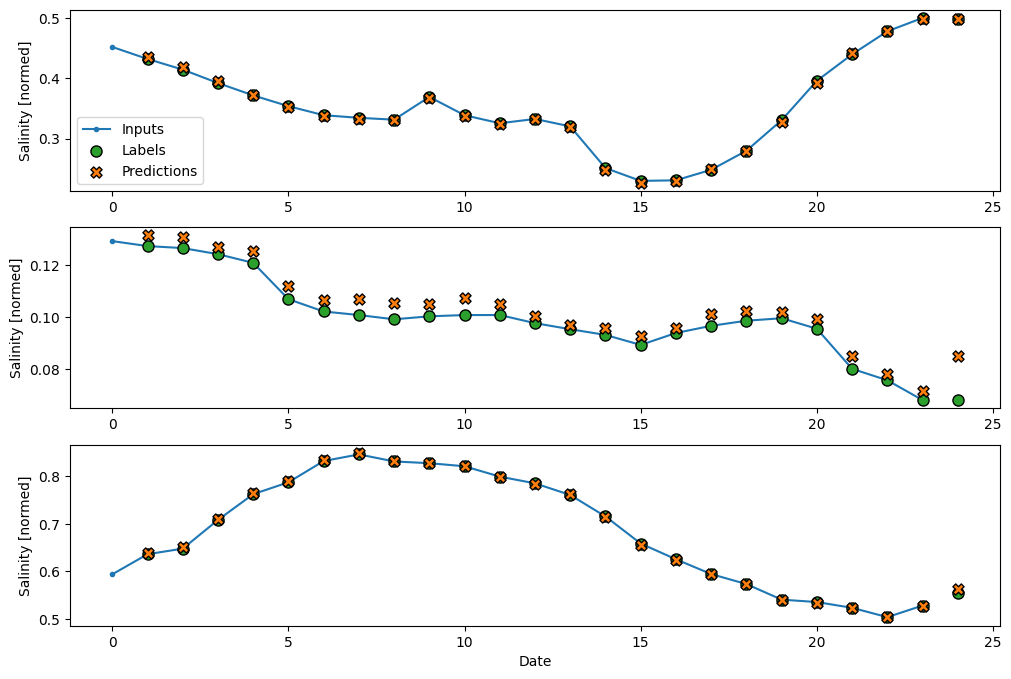

In [ ]:
wide_window.plot()

In [ ]:
# val_performance

In [ ]:
print(type(val_performance))  # Check the type of val_performance
print(type(performance))      # Check the type of performance

# Inspect the first few values
print(val_performance)  
print(performance)

<class 'dict'>
<class 'dict'>
{'Baseline': {'loss': 0.001502886414527893, 'mean_absolute_error': 0.02703125588595867}, 'LSTM_Model_64_2': [{'loss': 5.680678805219941e-05, 'mean_absolute_error': 0.003751940093934536}]}
{'Baseline': {'loss': 0.0014835352776572108, 'mean_absolute_error': 0.027310598641633987}, 'LSTM_Model_64_2': [{'loss': 4.653521318687126e-05, 'mean_absolute_error': 0.002798203844577074}]}


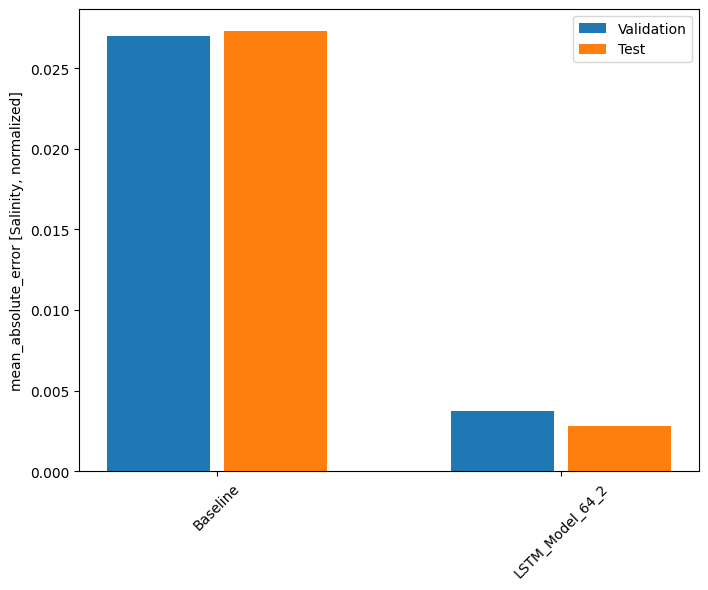

In [ ]:
# Safely access 'mean_absolute_error' regardless of the structure
def extract_metric(data, metric_name):
    result = []
    for key, value in data.items():
        if isinstance(value, dict):  # Case: value is a single dictionary
            result.append(value[metric_name])
        elif isinstance(value, list):  # Case: value is a list of dictionaries
            result.append(value[0][metric_name])  # Use the first dictionary in the list
    return result

# Extract values
val_mae = extract_metric(val_performance, 'mean_absolute_error')
test_mae = extract_metric(performance, 'mean_absolute_error')

# Plot the data
x = np.arange(len(performance))
width = 0.3

plt.ylabel('mean_absolute_error [Salinity, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.legend()
plt.show()

In [ ]:
# for name, value in performance.items():
#   print(f'{name:12s}: {value[metric_name]:0.8f}')

In [ ]:
for model_name, results in performance.items():
    print(f'{model_name}:')
    if isinstance(results, list):  # Check if there are multiple iterations for this model
        for idx, iteration in enumerate(results, start=1):
            print(f'    Iteration {idx} | Test MAE: {iteration["mean_absolute_error"]}')
    else:  # Single result (e.g., Baseline)
        print(f'    Test MAE: {results["mean_absolute_error"]:0.8f}')

Baseline:
    Test MAE: 0.02731060
LSTM_Model_64_2:
    Iteration 1 | Test MAE: 0.002798203844577074
